In [1]:
from cat.transmap_classify import *
import os
os.chdir('/public/groups/cgl/cat/primates_evan/')

genomes = ['Chimp',
 'Bonobo',
 'Gorilla',
 'Orangutan',
 'Gibbon',
 'Rhesus',
 'Owl_monkey',
 'Marmoset']

In [9]:
# get APPRIS
!wget http://apprisws.bioinfo.cnio.es/pub/current_release/datafiles/homo_sapiens/GRCh38/appris_data.principal.forENSEMBL.txt

--2020-03-07 11:48:22--  http://apprisws.bioinfo.cnio.es/pub/current_release/datafiles/homo_sapiens/GRCh38/appris_data.principal.forENSEMBL.txt
Resolving apprisws.bioinfo.cnio.es (apprisws.bioinfo.cnio.es)... 193.147.150.92
Connecting to apprisws.bioinfo.cnio.es (apprisws.bioinfo.cnio.es)|193.147.150.92|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1615177 (1.5M) [text/plain]
Saving to: ‘appris_data.principal.forENSEMBL.txt’

100%[======================================>] 1,615,177    545KB/s   in 2.9s   

2020-03-07 11:48:26 (545 KB/s) - ‘appris_data.principal.forENSEMBL.txt’ saved [1615177/1615177]



In [2]:
appris_df = pd.read_csv('appris_data.principal.forENSEMBL.txt', sep='\t', header=None)

In [3]:
# get strict set of transcripts
appris_df = appris_df[appris_df[2] == 'PRINCIPAL:1']
strict_txs = set(appris_df[1])

In [4]:
ref_gp_dict = tools.transcripts.get_gene_pred_dict('work/reference/gencode.v33.annotation.gff3.gp')
ref_fasta = tools.bio.get_sequence_dict('work/genome_files/Human.fa')
ref_psl_dict = tools.psl.get_alignment_dict('work/reference/gencode.v33.annotation.gff3.psl')

In [5]:
def codon_pair_iterator(ref_tx, tx, aln, fasta, ref_fasta):
    """
    Inputs:
    Transcript objects representing the annotation (query) transcript and the target transcript.
    PslRow object that represents the alignment between the transcript objects.
    pyfaidx Fasta objects that contain the genomic sequence for these two transcripts
    Order is (target_cds_pos, target, query)
    """
    target_cds = tx.get_cds(fasta)
    query_cds = ref_tx.get_cds(ref_fasta)
    cds_size = ref_tx.cds_size - ref_tx.offset
    for i in range(ref_tx.offset, cds_size - cds_size % 3, 3):
        target_cds_positions = []
        for ref_cds_coord in range(i, i + 3):
            ref_mrna_coord = ref_tx.cds_coordinate_to_mrna(ref_cds_coord)
            if ref_mrna_coord is None:
                print(ref_tx, i)
                target_cds_positions.append(None)
                continue
            chrom_coord = aln.query_coordinate_to_target(ref_mrna_coord)
            if chrom_coord is None:
                target_cds_positions.append(None)
            else:
                target_cds_positions.append(tx.chromosome_coordinate_to_cds(chrom_coord))
        if None in target_cds_positions:
            continue
        target_codon = target_cds[target_cds_positions[0]:target_cds_positions[0] + 3]
        query_codon = query_cds[i:i + 3]
        assert len(target_codon) == len(query_codon) == 3, ref_tx.name
        yield target_cds_positions[0], target_codon, query_codon


def dn_ds(ref_tx, tx, aln, fasta, ref_fasta):
    synon = 0
    non_synon = 0
    for pos, codon, ref_codon in codon_pair_iterator(ref_tx, tx, aln, fasta, ref_fasta):
        if codon == ref_codon:
            continue
        tgt_aa = tools.bio.translate_sequence(codon)
        ref_aa = tools.bio.translate_sequence(ref_codon)
        if tgt_aa == ref_aa:
            synon += 1
        else:
            non_synon += 1
    return synon, non_synon, tools.mathOps.format_ratio(non_synon, synon)


In [6]:
def filter_psl(psl):
    """Filter based on unique mappings and being in the strict transcript set"""
    alns = tools.psl.group_alignments_by_qname(tools.psl.psl_iterator(psl))
    return {y[0].q_name: y[0] for x, y in alns.items() if x.split('.')[0] in strict_txs and len(y) == 1}

In [7]:
dfs = []
for genome in genomes:
    psl = f'work/transMap/{genome}.psl'
    tm_gp = f'work/transMap/{genome}.gp'
    fasta = f'work/genome_files/{genome}.fa'
    alns = filter_psl(psl)
    gp_dict = tools.transcripts.get_gene_pred_dict(tm_gp)
    fasta = tools.bio.get_sequence_dict(fasta)
    
    r = []
    for i, (aln_id, aln) in enumerate(alns.items()):
        tx = gp_dict[aln_id]
        tx_id = tools.nameConversions.strip_alignment_numbers(aln_id)
        ref_aln = ref_psl_dict[tx_id]
        ref_tx = ref_gp_dict[tx_id]
        gene_id = ref_tx.name2
        synon, non_synon, result = dn_ds(ref_tx, tx, aln, fasta, ref_fasta)
        r.append([aln_id, tx_id, gene_id, synon, non_synon, result,
                  aln.coverage, aln.identity, genome])
        if i % 1000 == 0 and i != 0:
            print(genome, i)
    df = pd.DataFrame(r, columns=['AlignmentId', 'TranscriptId', 'GeneId', 'Synonymous',
                                  'Non-synonymous', 'dN/dS', 'Coverage', 'Identity',
                                 'Genome'])
    dfs.append(df)
combined_df = pd.concat(dfs)

Chimp 1000
Chimp 2000
Chimp 3000
Chimp 4000
Chimp 5000
Chimp 6000
Chimp 7000
Chimp 8000
Chimp 9000
Chimp 10000
Chimp 11000
Chimp 12000
Chimp 13000
Chimp 14000
Chimp 15000
Chimp 16000
Chimp 17000
Chimp 18000
Chimp 19000
Bonobo 1000
Bonobo 2000
Bonobo 3000
Bonobo 4000
Bonobo 5000
Bonobo 6000
Bonobo 7000
Bonobo 8000
Bonobo 9000
Bonobo 10000
Bonobo 11000
Bonobo 12000
Bonobo 13000
Bonobo 14000
Bonobo 15000
Bonobo 16000
Bonobo 17000
Bonobo 18000
Bonobo 19000
Gorilla 1000
Gorilla 2000
Gorilla 3000
Gorilla 4000
Gorilla 5000
Gorilla 6000
Gorilla 7000
Gorilla 8000
Gorilla 9000
Gorilla 10000
Gorilla 11000
Gorilla 12000
Gorilla 13000
Gorilla 14000
Gorilla 15000
Gorilla 16000
Gorilla 17000
Gorilla 18000
Gorilla 19000
Orangutan 1000
Orangutan 2000
Orangutan 3000
Orangutan 4000
Orangutan 5000
Orangutan 6000
Orangutan 7000
Orangutan 8000
Orangutan 9000
Orangutan 10000
Orangutan 11000
Orangutan 12000
Orangutan 13000
Orangutan 14000
Orangutan 15000
Orangutan 16000
Orangutan 17000
Orangutan 18000
Gibbon 

In [12]:
import seaborn as sns
%matplotlib inline

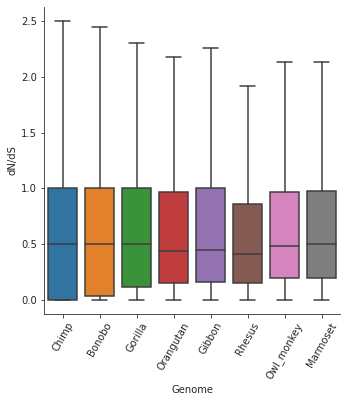

In [30]:
g = sns.catplot(data=combined_df, y='dN/dS', x='Genome', kind='box', order=genomes, showfliers=False)
g.set_xticklabels(rotation=60)

In [27]:
combined_df.groupby('Genome').size()

Genome
Bonobo        19815
Chimp         19823
Gibbon        18278
Gorilla       19261
Marmoset      14338
Orangutan     18976
Owl_monkey    14459
Rhesus        17330
dtype: int64

In [29]:
combined_df.dropna().groupby('Genome').size()

Genome
Bonobo        17865
Chimp         17748
Gibbon        17952
Gorilla       17929
Marmoset      14220
Orangutan     18588
Owl_monkey    14354
Rhesus        17173
dtype: int64

In [24]:
combined_df.fillna(0)[['Genome', 'dN/dS']].groupby('Genome').median()

,dN/dS
Genome,
Bonobo,0.400000
Chimp,0.375000
Gibbon,0.428571
Gorilla,0.400000
Marmoset,0.491830
Orangutan,0.428571
Owl_monkey,0.479452
Rhesus,0.400000


In [25]:
combined_df.to_csv('dn_ds.csv')